In [49]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For statistical modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Load data

In [21]:
# Data import
df = pd.read_csv('data/GenderPayGapCase.csv', sep=';', engine='python')

In [22]:
# check lenght
len(df)

4918

In [23]:
# Quick inspection
print("===== HEAD OF DATAFRAME =====")
print(df.head(), "\n")
    
print("===== DATAFRAME INFO =====")
print(df.info(), "\n")
    
print("===== DESCRIPTIVE STATISTICS =====")
print(df.describe(), "\n")

===== HEAD OF DATAFRAME =====
   sex              function  km_transport nationality contract_pct  \
0  Man  A330 Tweede Officier           NaN          NL          100   
1  Man  A330 Tweede Officier          44.0          NL          100   
2  Man  A330 Tweede Officier          43.0          NL          100   
3  Man  B737 Eerste officier          61.0          NL          100   
4  Man  B737 Eerste officier          71.0          NL          100   

   base_salary    clob  nr_managers_above  manager  direct CLA_domain  \
0  6,981759595  clob_4                  4        0       0    Cockpit   
1  6,747505918  clob_4                  4        0       0    Cockpit   
2  7,072163078  clob_4                  4        0       0    Cockpit   
3  7,256418254  clob_4                  4        0       0    Cockpit   
4  7,206537057  clob_4                  4        0       0    Cockpit   

   grading maritalstatus  years_of_services  age  
0  grade_3  Relationship                  3   33  
1 

# Data preparation

In [24]:
# Create data type map
dtype_map = {
    'sex': 'category',
    'function': 'category',
    'km_transport': 'float',        
    'nationality': 'category',
    'contract_pct': 'float',
    'base_salary': 'float',
    'clob': 'category',               # category as it means "Cluster line of business: grouping of departments"
    'nr_managers_above': 'Int64',   # keep it as int as it might be used for calc
    'manager': 'boolean',       
    'CLA_domain': 'category',
    'grading': 'category',
    'maritalstatus': 'category',
    'years_of_services': 'Int64',   
    'age': 'category'                  # use it as age category later, keep it as category
}

In [25]:
# Transform columns with the proper dtypes
#  Convert manager from 1/0 to booleans
if 'manager' in df.columns:
    df['manager'] = df['manager'].map({1: True, 0: False})
    dtype_map['manager'] = 'boolean'

# Convert direct from 1/0 to booleans
if 'direct' in df.columns:
    df['direct'] = df['direct'].map({1: True, 0: False})
    dtype_map['direct'] = 'boolean'

# Fix float values
columns_with_commas = ['contract_pct', 'base_salary']
for col in columns_with_commas:
    # Replace comma with dot, then convert to float
    df[col] = df[col].str.replace(',', '.').astype(float)

# Apply data type map
# -----------------------------------------------------------------------------
for col, dtype in dtype_map.items():
    if col in df.columns:
        try:
            df[col] = df[col].astype(dtype)
        except ValueError as e:
            print(f"Could not convert column '{col}' to {dtype}: {e}")

# Verify results 
print("===== Data Types After Conversion =====")
print(df.dtypes)
print("\n===== Preview of DataFrame =====")
print(df.head())

===== Data Types After Conversion =====
sex                  category
function             category
km_transport          float64
nationality          category
contract_pct          float64
base_salary           float64
clob                 category
nr_managers_above       Int64
manager               boolean
direct                boolean
CLA_domain           category
grading              category
maritalstatus        category
years_of_services       Int64
age                  category
dtype: object

===== Preview of DataFrame =====
   sex              function  km_transport nationality  contract_pct  \
0  Man  A330 Tweede Officier           NaN          NL         100.0   
1  Man  A330 Tweede Officier          44.0          NL         100.0   
2  Man  A330 Tweede Officier          43.0          NL         100.0   
3  Man  B737 Eerste officier          61.0          NL         100.0   
4  Man  B737 Eerste officier          71.0          NL         100.0   

   base_salary    clob  nr_ma

# EDA

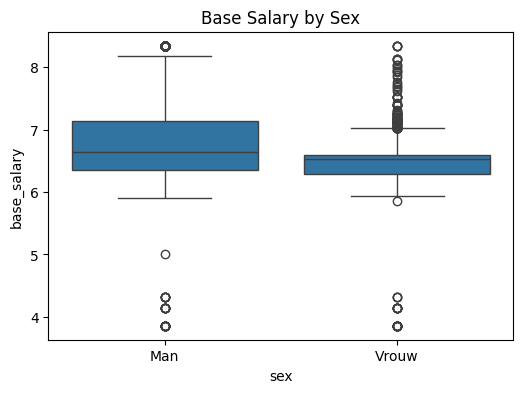

===== AVERAGE SALARY BY SEX =====
sex
Man      6.797703
Vrouw    6.479903
Name: base_salary, dtype: float64 

===== AVERAGE SALARY BY SEX AND MANAGER STATUS =====
sex    manager
Man    False      6.781053
       True       7.066233
Vrouw  False      6.465389
       True       7.027439
Name: base_salary, dtype: float64 



C:\Users\skepesi\AppData\Local\Temp\ipykernel_13060\848848636.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_salary_by_sex = df.groupby('sex')['base_salary'].mean()
C:\Users\skepesi\AppData\Local\Temp\ipykernel_13060\848848636.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(['sex', 'manager'])['base_salary'].mean(), "\n")


In [26]:
# Distribution of Base Salary by Sex
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='sex', y='base_salary')
plt.title("Base Salary by Sex")
plt.show()

# 4.2 Group-Level Summary
avg_salary_by_sex = df.groupby('sex')['base_salary'].mean()
print("===== AVERAGE SALARY BY SEX =====")
print(avg_salary_by_sex, "\n")

# If there's a "manager" column (0/1, Yes/No, or boolean),
# calculate average salary by sex & manager status
if 'manager' in df.columns:
    print("===== AVERAGE SALARY BY SEX AND MANAGER STATUS =====")
    print(df.groupby(['sex', 'manager'])['base_salary'].mean(), "\n")


In [27]:
# Analyze further the distribution of base salary per sex
df['mean_salary_by_sex'] = df.groupby('sex')['base_salary'].transform('mean')

# 2. Check if an employee's salary is below or above their own group's mean
df['below_mean'] = df['base_salary'] < df['mean_salary_by_sex']
df['above_mean'] = df['base_salary'] > df['mean_salary_by_sex']

# 3. Count how many are below or above, by sex
counts_below = df.groupby('sex')['below_mean'].sum()
counts_above = df.groupby('sex')['above_mean'].sum()

print("===== EMPLOYEES BELOW AVERAGE BY SEX =====")
print(counts_below, "\n")

print("===== EMPLOYEES ABOVE AVERAGE BY SEX =====")
print(counts_above, "\n")

# (Optional) We can also calculate percentages:
group_sizes = df['sex'].value_counts()
percent_below = (counts_below / group_sizes * 100).round(2)
percent_above = (counts_above / group_sizes * 100).round(2)

print("===== PERCENT BELOW AVERAGE BY SEX =====")
print(percent_below, "\n")

print("===== PERCENT ABOVE AVERAGE BY SEX =====")
print(percent_above, "\n")


===== EMPLOYEES BELOW AVERAGE BY SEX =====
sex
Man      1607
Vrouw     898
Name: below_mean, dtype: int64 

===== EMPLOYEES ABOVE AVERAGE BY SEX =====
sex
Man      1065
Vrouw    1348
Name: above_mean, dtype: int64 

===== PERCENT BELOW AVERAGE BY SEX =====
sex
Man      60.14
Vrouw    39.98
dtype: float64 

===== PERCENT ABOVE AVERAGE BY SEX =====
sex
Man      39.86
Vrouw    60.02
dtype: float64 



C:\Users\skepesi\AppData\Local\Temp\ipykernel_13060\88950258.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['mean_salary_by_sex'] = df.groupby('sex')['base_salary'].transform('mean')
C:\Users\skepesi\AppData\Local\Temp\ipykernel_13060\88950258.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_below = df.groupby('sex')['below_mean'].sum()
C:\Users\skepesi\AppData\Local\Temp\ipykernel_13060\88950258.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt 

In [28]:
# Calculate the raw gender pay gap
male_avg = df.loc[df['sex'] == 'Man', 'base_salary'].mean()
female_avg = df.loc[df['sex'] == 'Vrouw', 'base_salary'].mean()

# Raw pay gap as percentage difference relative to male average
raw_gap_percentage = ((male_avg - female_avg) / male_avg) * 100
print(f"Raw Gender Pay Gap (female vs male): {raw_gap_percentage:.2f}%\n")

Raw Gender Pay Gap (female vs male): 4.68%



In [29]:
# Check functions
df.function.unique().tolist()

['A330 Tweede Officier',
 'B737 Eerste officier',
 'B777 Eerste Officier',
 'B777 Tweede Officier',
 'A330 Eerste Officier',
 'B737 Gezagvoerder',
 'A32N Gezagvoerder',
 'A330 Gezagvoerder',
 'B777 Gezagvoerder',
 'E190 Co piloot',
 'E190 Gezagvoerder',
 'function_x',
 'Cabin Attendant',
 'Cabin Supervisor KLC',
 'Senior Cabin Attendant',
 'Cabin Attendant 1',
 'Purser',
 'Cabin Attendant 2',
 'Senior Purser',
 'Assistant Purser',
 'Employee Back Office HR SSC Level 1']

In [30]:
# Check proportion of function_x 
len(df[df.function=='function_x'])/len(df)*100

48.53599023993493

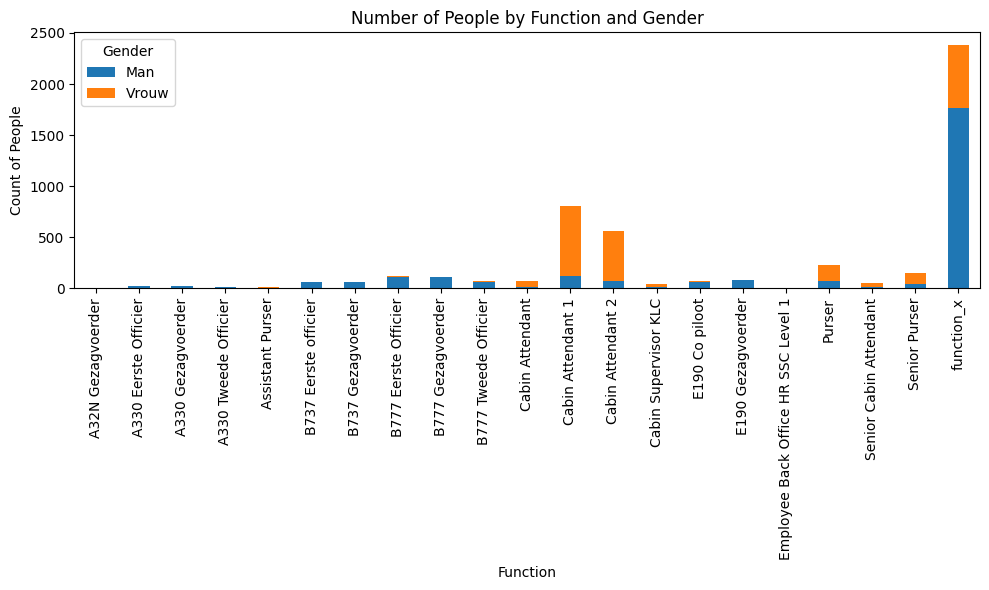

In [31]:
# Check proprotion of genders in each function
# Build a cross-tab to count people (rows) for each combination of 'function' and 'sex'
counts = pd.crosstab(df['function'], df['sex'])

# Create a stacked bar plot
ax = counts.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6),
    title="Number of People by Function and Gender"
)

# Axis labels and legend
ax.set_xlabel("Function")
ax.set_ylabel("Count of People")
plt.legend(title="Gender", loc="best")

plt.tight_layout()
plt.show()

In [32]:
# Create base salary bins
bins = [0, 4, 5, 6, 7, 8, float('inf')]
bin_labels = ['<4k', '4k-5k', '5k-6k', '6k-7k', '7k-8k', '>8k']

df['salary_bin'] = pd.cut(
    df['base_salary'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True
)

# Count how many employees fall into each bin
bin_counts = df['salary_bin'].value_counts(sort=False)

print("== Aggregated Bin Counts ==")
print(bin_counts)

== Aggregated Bin Counts ==
salary_bin
<4k        36
4k-5k      25
5k-6k      55
6k-7k    3669
7k-8k     901
>8k       232
Name: count, dtype: int64


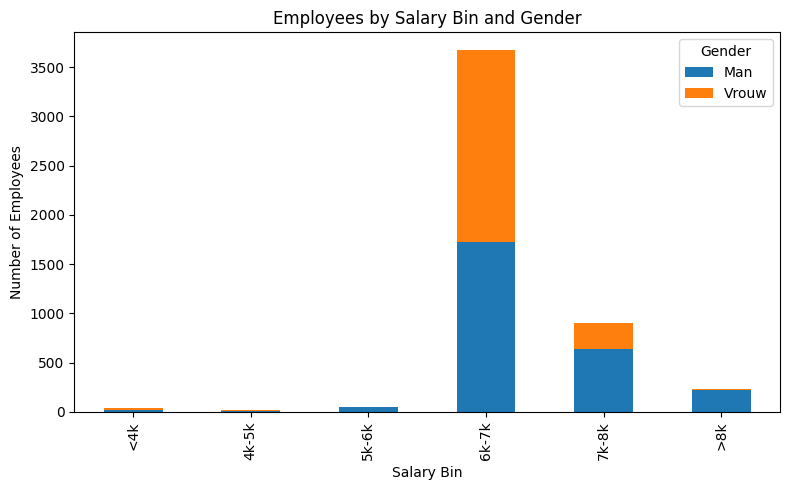

In [33]:
# Check proportion of genders per each salary bin
counts = pd.crosstab(df['salary_bin'], df['sex'])

# 3. Plot a stacked bar chart
ax = counts.plot(kind='bar', stacked=True, figsize=(8, 5))
ax.set_title("Employees by Salary Bin and Gender")
ax.set_xlabel("Salary Bin")
ax.set_ylabel("Number of Employees")

plt.legend(title="Gender", loc="best")
plt.tight_layout()
plt.show()

In [35]:
# Define the bins of interest
bins_of_interest = ['7k-8k', '>8k']

# Filter DataFrame to only those bins
df_sub = df[df['salary_bin'].isin(bins_of_interest)].copy()

# Crosstab: Rows = function, Columns = (salary_bin, sex)
counts = pd.crosstab(
    index=df_sub['function'],
    columns=[df_sub['salary_bin'], df_sub['sex']]
)

# Flatten the multi-level columns into single strings,
#    e.g. ("7k-8k", "Man") -> "7k-8k_Man_count"
counts_flat = counts.copy()
counts_flat.columns = [
    f"{bin_label}_{gender}_count" for bin_label, gender in counts_flat.columns
]

# Calculate row-wise percentages
pcts = counts.div(counts.sum(axis=1), axis=0).mul(100)

# Flatten the percentage columns similarly,
#    e.g. ("7k-8k", "Man") -> "7k-8k_Man_pct"
pcts_flat = pcts.copy()
pcts_flat.columns = [
    f"{bin_label}_{gender}_pct" for bin_label, gender in pcts_flat.columns
]

# Combine counts and percentages side by side
final_df = pd.concat([counts_flat, pcts_flat], axis=1)

# Sort the final DataFrame by a specific column, e.g. >8k_Man_count descending
print("\n=== Final DataFrame with Counts and Percentages by (Bin, Gender) ===")
final_df


=== Final DataFrame with Counts and Percentages by (Bin, Gender) ===


,7k-8k_Man_count,7k-8k_Vrouw_count,>8k_Man_count,>8k_Vrouw_count,7k-8k_Man_pct,7k-8k_Vrouw_pct,>8k_Man_pct,>8k_Vrouw_pct
function,,,,,,,,
A32N Gezagvoerder,0,0,1,0,0.000000,0.000000,100.000000,0.000000
A330 Eerste Officier,13,1,7,0,61.904762,4.761905,33.333333,0.000000
A330 Gezagvoerder,0,0,23,1,0.000000,0.000000,95.833333,4.166667
A330 Tweede Officier,3,0,0,0,100.000000,0.000000,0.000000,0.000000
B737 Eerste officier,50,5,0,0,90.909091,9.090909,0.000000,0.000000
B737 Gezagvoerder,9,0,50,4,14.285714,0.000000,79.365079,6.349206
B777 Eerste Officier,82,3,29,3,70.085470,2.564103,24.786325,2.564103
B777 Gezagvoerder,0,0,107,3,0.000000,0.000000,97.272727,2.727273
B777 Tweede Officier,43,4,0,0,91.489362,8.510638,0.000000,0.000000



=== Final DataFrame with Counts and Percentages by (Bin, Gender) ===


,7k-8k_Man_count,7k-8k_Vrouw_count,>8k_Man_count,>8k_Vrouw_count,7k-8k_Man_pct,7k-8k_Vrouw_pct,>8k_Man_pct,>8k_Vrouw_pct
function,,,,,,,,
A32N Gezagvoerder,0,0,1,0,0.000000,0.000000,100.000000,0.000000
A330 Eerste Officier,13,1,7,0,61.904762,4.761905,33.333333,0.000000
A330 Gezagvoerder,0,0,23,1,0.000000,0.000000,95.833333,4.166667
A330 Tweede Officier,3,0,0,0,100.000000,0.000000,0.000000,0.000000
B737 Eerste officier,50,5,0,0,90.909091,9.090909,0.000000,0.000000



=== Melted DataFrame of ONLY PERCENTAGES ===


,function,pct,bin,gender
0,A32N Gezagvoerder,0.000000,7k-8k,Man
1,A330 Eerste Officier,61.904762,7k-8k,Man
2,A330 Gezagvoerder,0.000000,7k-8k,Man
3,A330 Tweede Officier,100.000000,7k-8k,Man
4,B737 Eerste officier,90.909091,7k-8k,Man


C:\Users\skepesi\AppData\Local\Temp\ipykernel_13060\3098632886.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\skepesi\AppData\Local\Temp\ipykernel_13060\3098632886.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


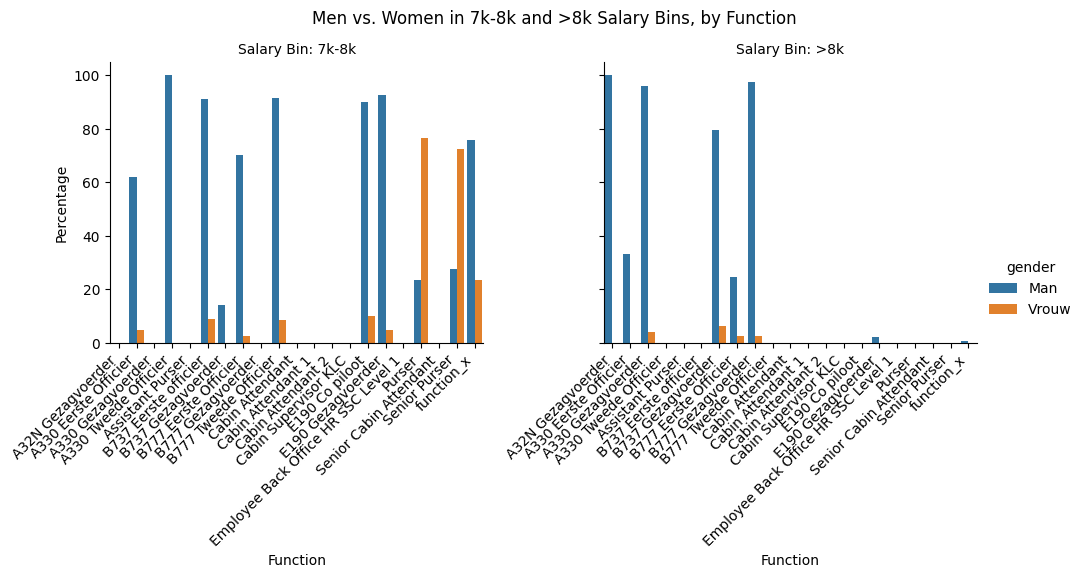

In [ ]:
# Reshape the DataFrame to a 'long' format for plotting the PERCENTAGE columns
# Filter only columns that end with "_pct"
pct_cols = [c for c in final_df.columns if c.endswith("_pct")]

# Create dataframe
df_pct_long = (
    final_df[pct_cols]
    .reset_index()          # bring 'function' from index to a column
    .melt(
        id_vars='function',
        var_name='bin_gender',
        value_name='pct'
    )
)

# Safely split bin_gender (like "7k-8k_Man_pct") into [bin, gender, _dummy]
def parse_bin_gender(x):
    parts = x.split('_')       # e.g. ['7k-8k','Man','pct']
    # If not exactly 3 parts, fix by padding or slicing
    parts = (parts + [""]*3)[:3]
    return pd.Series(parts, index=['bin', 'gender', '_dummy'])

df_pct_long[['bin', 'gender', '_dummy']] = df_pct_long['bin_gender'].apply(parse_bin_gender)

# Drop the original bin_gender and the _dummy column (which is always "pct")
df_pct_long.drop(columns=['bin_gender', '_dummy'], inplace=True)

print("\n=== Melted DataFrame of ONLY PERCENTAGES ===")
display(df_pct_long.head())

# Visualize results
g = sns.catplot(
    data=df_pct_long,
    x='function',
    y='pct',
    hue='gender',
    col='bin',
    kind='bar',
    height=4,
    aspect=1.2
)

# Set facet titles and axis labels
g.set_titles("Salary Bin: {col_name}")
g.set_axis_labels("Function", "Percentage")

# Rotate x-axis labels on each subplot
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust the subplot spacing, add a main title
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Men vs. Women in 7k-8k and >8k Salary Bins, by Function")
plt.show()


# Investigate pay gap Linear Regression (OLS) 

**Model Formula**: base_salary ~ sex_binary + years_of_services + contract_pct + manager  
**R-squared** ≈ 0.153: About 15% of the variation in base salary is explained by these four predictors, suggesting other important factors are not captured in this model.  
**Sex Binary** (Man=1 vs. Woman=0): The coefficient 0.3471 is positive and statistically significant (p < 0.0001). **This indicates that, on average, men earn roughly 0.3471 more in the chosen `base_salary` units than women**, holding other factors constant.  
**Years of Services**: The coefficient 0.0138 is also highly significant, showing **salaries tend to increase with additional years of experience**.  
**Contract Percentage**: A small negative coefficient (-0.0037) suggests that, in this dataset,** higher contract percentages are associated with slightly lower `base_salary`** when the other variables are held constant. This might reflect how part-time/full-time roles map to different positions or pay scales in the data.  
**Manager**: Estimated as 0 with NaN standard errors, implying it adds no independent variation—likely because it’s constant or perfectly collinear with another variable.  
Collinearity Warning: The note about the smallest eigenvalue = 0 and a divide by zero indicates a singular design matrix. This typically means at least one variable (e.g., `manager`) does not vary across observations or is fully determined by the other predictors.  
Overall, the regression suggests a remaining pay gap for men vs. women, even after controlling for tenure and contract percentage. However, the model’s relatively low R-squared value and the collinearity warning signal that additional data (e.g., role, grading, or department) may be needed to fully explain salary variations and interpret the pay gap more accurately.


In [ ]:
# Using stats model to investigate the gap
# Create a binary column for sex: 1 = Man, 0 = Vrouw 
df['sex_binary'] = np.where(df['sex'] == 'Man', 1, 0)

# Convert manager to numeric, intend to treat “manager” as a numeric predictor with two levels, convert to 0/1:
df['manager'] = df['manager'].map({True: 1, False: 0})
df['manager'] = pd.to_numeric(df['manager'], errors='coerce').fillna(0)


# Build the Regression Formula
formula_parts = ["sex_binary"]  
if 'years_of_services' in df.columns:
    formula_parts.append("Q('years_of_services')")
if 'contract_pct' in df.columns:
    formula_parts.append("Q('contract_pct')")
if 'manager' in df.columns:
    formula_parts.append("manager")

# Example formula: base_salary ~ sex_binary + years_of_services + ...
formula_str = "Q('base_salary') ~ " + " + ".join(formula_parts)
print(f"Using formula: {formula_str}\n")

# Fit the Model
model = smf.ols(formula=formula_str, data=df).fit()
print(model.summary())


Using formula: Q('base_salary') ~ sex_binary + Q('years_of_services') + Q('contract_pct') + manager

                            OLS Regression Results                            
Dep. Variable:       Q('base_salary')   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     244.6
Date:                Sun, 09 Mar 2025   Prob (F-statistic):          6.84e-192
Time:                        22:18:04   Log-Likelihood:                -4195.0
No. Observations:                4918   AIC:                             8400.
Df Residuals:                    4913   BIC:                             8433.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------

# Investigate pay gap with Oaxaca–Blinder

**Men earn an average base salary of 6.798, while women earn 6.480, for a raw gap of about 0.318 units.**   
The **men-only OLS explains only about 8% of salary variation, whereas the women-only OLS explains 30%.** This difference suggests that **women’s pay correlates more strongly with years of service or managerial status**, whereas **men’s salaries might be influenced by additional unmeasured factors** (e.g., role type, department, or performance).  
Oaxaca–Blinder shows a relatively small explained portion (0.075) and a **larger unexplained portion (0.523)**, indicating that most of the **gap (in this setup) is not accounted for by years of service, contract percentage, or manager status alone**.  
Future analyses should consider more detailed role classifications (e.g., job level, department), potential performance metrics, and other variables that might account for the large unexplained gap. Moreover, the negative coefficient for contract percentage among men is worth further investigation to understand how contract patterns associate with pay scales. 


In [ ]:
# Columns we care about
regressors = ['years_of_services', 'contract_pct', 'manager']
cols_to_convert = ['base_salary'] + regressors

# Ensure all relevant columns are numeric
for col in cols_to_convert:
    if col in df.columns:
        # Convert to numeric and coerce invalid strings to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # If it remains an extension dtype like Int64, convert to a standard type (int64/float64)
        if pd.api.types.is_integer_dtype(df[col].dtype):
            df[col] = df[col].astype('int64')   # or 'float64' if you prefer
        # Optionally fill NaNs, if you want to treat them as 0. Otherwise, we'll drop them below.

# Drop rows with missing values in these key columns
df.dropna(subset=cols_to_convert, inplace=True)

# Split data by sex
df_man = df[df['sex'] == 'Man']
df_woman = df[df['sex'] == 'Vrouw']

# Build design matrices for men and women
X_man = sm.add_constant(df_man[regressors], prepend=True)
y_man = df_man['base_salary']

X_woman = sm.add_constant(df_woman[regressors], prepend=True)
y_woman = df_woman['base_salary']

# Fit separate OLS models
model_man = sm.OLS(y_man, X_man).fit()
model_woman = sm.OLS(y_woman, X_woman).fit()

print("\n=== OLS for Men ===")
print(model_man.summary())

print("\n=== OLS for Women ===")
print(model_woman.summary())

# Oaxaca–Blinder Decomposition
# Common formula:
# Gap = (X_man_mean - X_woman_mean) * beta_woman + X_woman_mean * (beta_man - beta_woman)

# Mean of regressors
X_man_mean = X_man.mean()
X_woman_mean = X_woman.mean()

# Coefficients (betas)
beta_man = model_man.params
beta_woman = model_woman.params

# Raw gap (mean salary men - mean salary women)
mean_man_salary = y_man.mean()
mean_woman_salary = y_woman.mean()
raw_gap = mean_man_salary - mean_woman_salary

# "Explained" portion
explained = (X_man_mean - X_woman_mean).dot(beta_woman)

# "Unexplained" portion
unexplained = X_woman_mean.dot(beta_man - beta_woman)

print("\n=== Oaxaca–Blinder Decomposition ===")
print(f"Mean Salary (Men)    = {mean_man_salary:.3f}")
print(f"Mean Salary (Women)  = {mean_woman_salary:.3f}")
print(f"Raw Gap (Men-Women)  = {raw_gap:.3f}\n")

print(f"Explained Portion    = {explained:.3f}")
print(f"Unexplained Portion  = {unexplained:.3f}")
print("Check: explained + unexplained should approximate raw_gap.\n")



=== OLS for Men ===
                            OLS Regression Results                            
Dep. Variable:            base_salary   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     81.68
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           1.49e-50
Time:                        22:35:22   Log-Likelihood:                -2722.7
No. Observations:                2672   AIC:                             5453.
Df Residuals:                    2668   BIC:                             5477.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const            